## Uniform Crime Reporting Program - FBI

Scrape data from https://ucr.fbi.gov/ucr-publications corresponding to the number of murders in certain metropolitan regions from 2006 to 2016. For each year, you will programmatically navigate to violent crimes, and then to murders, and scrape the table corresponding to Metropolitan Statistical Areas (MSAs). Along with the numerical data, you will also want to scrape and save the text descriptions on violent crimes and murders.

In [59]:
import pandas as pd
import urllib
import numpy as np
import warnings
from fuzzywuzzy import process, fuzz
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Additional Reference Data of each MSA

In [2]:
##############
# LOAD MSA_ID file (Source - https://www.bea.gov/regional/docs/msalist.cfm)
##############
msa_lkp = pd.read_csv('data/state_MSA.csv',header=None,usecols=range(2,4))
#Rename Columns and remove duplicate entries
msa_lkp.columns = ['MSA_id','MSA']
msa_lkp.drop_duplicates(inplace=True)

#Remove the text "Metropolitan Statistical Area" from description
msa_lkp['MSA'] = msa_lkp['MSA'].str.replace(' \(Metropolitan Statistical Area\)','')

##############
# LOAD MSA_Lat Long file (Source - Tableau Firebird Database)
##############
msa_lat_long = pd.read_csv('data/MSA_Lat_Long_Values.csv')
msa_lat_long.columns=['MSA','Latitude','Longitude']

#Merge the two dataframes
msa_lkp = msa_lkp.merge(msa_lat_long, how='left', on='MSA')

In [3]:
"""
function
-----------
fbi_url_generator

This function pulls violent crime spreadsheets from FBI UCR website
for a given year

It takes in the year of interest and outputs a url string
"""
def fbi_url_generator(year):
    if 2006 <= year <= 2009:
        return('https://www2.fbi.gov/ucr/cius%i/data/documents/'%year +str(year)[2:]+'tbl06.xls')
    else:
        if 2010 <= year <= 2011:
            end = '/tables/table-6/output.xls'
        elif 2012 <= year <= 2013:
            end = '/tables/6tabledatadecpdf/table-6/output.xls'
        elif 2014 <= year <= 2015:
            if year == 2014:
                mid = 'Table_6_Crime_in_the_United_States_by_Metropolitan_Statistical_Area_2014/output.xls'
            else:
                mid = 'table_6_crime_in_the_united_states_by_metropolitan_statistical_area_%i.xls/output.xls' %year
            end = '/tables/table-6/%s' %mid
        elif year == 2016:
            end ='/tables/table-4/table-4/output.xls' 
        hostname = 'https://ucr.fbi.gov/crime-in-the-u.s/%i/crime-in-the-u.s.-%i' %(year, year)
        return(hostname + end)
    

In [4]:
"""
Function
--------
append_df

This function appends two dataframes

Parameters:
    input - dataframe to be appended
    output - dataframe to be appended onto
    
Returns a single dataframe 
"""
def append_df(input,output):
    if output.empty:
        output=input.copy()
    else:
        output=pd.concat([output,input])
        output.reset_index(drop='Index',inplace=True)
    return(output)

In [5]:
"""
# THIS CODE ONLY NEEDS TO BE RUN ONCE TO BRING IN ALL OF THE EXCEL FILES
version='Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36'
test=urllib.request.URLopener()
test.addheader('User-Agent',version)
for year in range(2006, 2017):
    print("Pulling: %i" %year)
    test.retrieve(url=fbi_url_generator(year),filename='data/crime_%i.xls' %year)
"""

'\n# THIS CODE ONLY NEEDS TO BE RUN ONCE TO BRING IN ALL OF THE EXCEL FILES\nversion=\'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36\'\ntest=urllib.request.URLopener()\ntest.addheader(\'User-Agent\',version)\nfor year in range(2006, 2017):\n    print("Pulling: %i" %year)\n    test.retrieve(url=fbi_url_generator(year),filename=\'data/crime_%i.xls\' %year)\n'

In [6]:
df_allyears = pd.DataFrame()
for year in range(2006, 2017):
    df = pd.read_excel("data/crime_%i.xls" %year,skiprows=[0,1],header=1)

    #######
    # NOTE - misc column has msa population, city population and estimate percentage
    ######
    df=df.iloc[:,0:12] 
    df.columns=['MSA', 'counties','misc', 'violent_crime','mur_mans', 'rape', 'robbery',
                'assault', 'property', 'burglary', 'larceny','mv_theft']

    # Drop footnotes
    footnotes = df['MSA'].str[0].str.isdigit().fillna(False)
    df = df.loc[~footnotes, :]
    
    #Drop blank rows
    df = df.dropna(how='all')

    # Get rid of numbers in MSA
    df['MSA'] = df['MSA'].str.replace('\d+', '')
    # Set empty columns to NaN for MSA
    df['MSA'] = df['MSA'].replace(' ', np.nan, regex=False)
    
    # Sometimes city  names get put in MSA column
    # Messes up carry forward
    df.loc[df['MSA'].str.contains("City of").fillna(False), "MSA"] = np.nan

    # Carry MSA name forward to fill in for all cells
    df.loc[:,'MSA'] = df.loc[:, 'MSA'].fillna(method='ffill')

    ##############
    # POPULATION - grab population and fill in for all MSA
    ##############
    pop_row = df.counties.isnull()
    pop = df.loc[pop_row, ["MSA", 'misc']]
    pop = pop.rename(index=str, columns={'misc': 'msa_pop'})
    
    # Merge population back in
    df = df.loc[~pop_row, :]
    df = df.merge(pop, how='outer', on='MSA')

    ################
    # Descriptions - don't need county descriptions 
    ################
    df = df.loc[df.counties.str.contains("Includes") == False, :]


    ###########################################
    # GOING LONG TO WIDE FOR CRIME VARIABLES
    ###########################################
    crime_vars = ['violent_crime','mur_mans', 'rape', 'robbery',
                  'assault', 'property', 'burglary', 'larceny','mv_theft']

    #########
    # CITIES
    #########
    city_vars = ['MSA', 'counties', 'misc'] + crime_vars
    # Split data Frame
    cities = df.counties.str.contains("City")
    city_df = df.loc[cities, city_vars]
    city_df = city_df.rename(index=str, columns={'misc': 'city_pop'})
    
    # Grab largest city for each MSA and merge back on
    city_df = city_df.sort_values(['MSA','city_pop'], ascending=False)
    large_city = city_df.groupby('MSA').first().reset_index()

    # Rename crime variables to denote city only crime 
    large_city.columns = ['MSA', 'counties', 'city_pop'] + ['city_' + i for i in crime_vars]
    large_city = large_city.rename(index=str, columns={'counties':'largest_city'})
    # Get rid of "City of"
    large_city.loc[:,'largest_city'] = large_city.loc[:, 'largest_city'].str.replace('City of','')
    
    # Merge back to main dataframe
    df = df.loc[~cities, ]
    df = df.merge(large_city, how='outer', on='MSA')

    ###############
    # CRIME RATE
    ###############
    rates = df.counties.str.contains("Rate per")
    rate_vars = ['MSA'] + crime_vars
    rates_df = df.loc[rates, rate_vars]
    rates_df.columns = ['MSA'] + ['rate_' + i for i in crime_vars]

    df = df.loc[~rates, :]
    df = df.merge(rates_df, how='outer', on='MSA')

    ########################
    # MSA-WIDE CRIME STATS
    ########################

    # If the entire MSA reported then there is just one row of numbers
    # If the entire MSA did not report, then there are two rows
            # first row is areas that reported
            # second report is an estimated total
    # We are going to grab the estimates total so our data
    # reflects all areas for all MSA

    # Create Flag for those that do not have complete coverage
    # and are thus estimates
    mins = df.groupby('MSA').misc.min().reset_index()
    mins.columns = ['MSA', 'min_coverage']
    df = df.merge(mins, how='outer', on='MSA')
    df['estimate'] = 0
    df.loc[df.min_coverage < 1, 'estimate'] = 1
    del df['min_coverage']

    # Now only keeping rows with coverage = 1
    # will either be all area or the estimate for all area
    df = df.loc[df.misc == 1, :]

    # Now no longer need coverage or whether its estimate or not
    del df['misc']
    del df['counties']
    
    df['year'] = year
    
    # Append to existing Frame
    df_allyears = append_df(df, df_allyears)

In [7]:
df_allyears = df_allyears.sort_values(["MSA", 'year'])
print(df_allyears.columns)
df_allyears.head()

Index(['MSA', 'violent_crime', 'mur_mans', 'rape', 'robbery', 'assault',
       'property', 'burglary', 'larceny', 'mv_theft', 'msa_pop',
       'largest_city', 'city_pop', 'city_violent_crime', 'city_mur_mans',
       'city_rape', 'city_robbery', 'city_assault', 'city_property',
       'city_burglary', 'city_larceny', 'city_mv_theft', 'rate_violent_crime',
       'rate_mur_mans', 'rate_rape', 'rate_robbery', 'rate_assault',
       'rate_property', 'rate_burglary', 'rate_larceny', 'rate_mv_theft',
       'estimate', 'year'],
      dtype='object')


,MSA,violent_crime,mur_mans,rape,robbery,assault,property,burglary,larceny,mv_theft,...,rate_mur_mans,rate_rape,rate_robbery,rate_assault,rate_property,rate_burglary,rate_larceny,rate_mv_theft,estimate,year
0,"Abilene, TX M.S.A.",638,6,75,109,448,5741,1531,3852,358,...,3.7,46.1,67,275.2,3526.9,940.6,2366.4,219.9,0,2006
357,"Abilene, TX M.S.A.",748,10,103,173,462,5657,1606,3708,343,...,6.3,65.3,109.7,292.9,3586.9,1018.3,2351.1,217.5,0,2007
721,"Abilene, TX M.S.A.",716,7,95,188,426,5124,1417,3443,264,...,4.4,59.7,118,267.5,3217.4,889.8,2161.9,165.8,0,2008
1078,"Abilene, TX M.S.A.",741,7,134,146,454,5607,1488,3816,303,...,4.4,83.9,91.5,284.4,3512.5,932.1,2390.5,189.8,0,2009
1456,"Abilene, TX M.S.A.",675,5,78,116,476,5772,1610,3925,237,...,3.1,48.9,72.7,298.3,3617.3,1009,2459.8,148.5,0,2010


## Exploratory Data Analysis

In [103]:
filter=df_allyears['MSA'].str.contains(' M.D.')
df_allyears=df_allyears[~filter]

In [104]:
#Create join key to integration across multiple sources
#Use first city and State as Key
df_allyears['city_key'] = df_allyears['MSA'].str.replace(' M.S.A.','').str.split(",").str[0]
df_allyears['city_key'] = df_allyears['city_key'].str.split("-").str[0].str.strip()
df_allyears['state_key']=df_allyears['MSA'].str.replace(' M.S.A.','').str.split(",").str[1].str.strip()

In [129]:
plt_df=df_allyears.loc[:,['city_key','state_key','year','violent_crime','msa_pop']].groupby(['city_key','state_key','year']).sum()
plt_df.reset_index(level=['city_key','state_key','year'],inplace=True)
plt_df['join_key'] = plt_df['city_key'].str.cat(plt_df['state_key'],sep='-')
plt_df['crime_rate'] = plt_df['violent_crime']/plt_df['msa_pop']

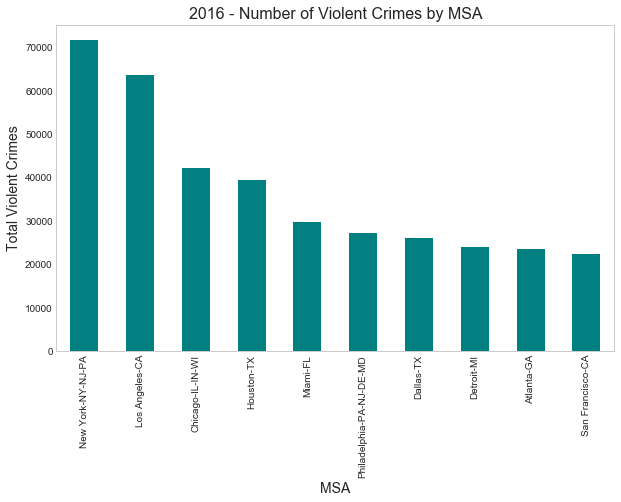

In [123]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax=plt_df[plt_df['year']==2016].groupby('join_key')['violent_crime'].sum().sort_values(ascending=False).iloc[0:10].plot(kind='bar',color='teal',grid=False)
ax.set_title('2016 - Number of Violent Crimes by MSA', fontsize=16)
ax.set_xlabel('MSA',fontsize=14)
ax.set_ylabel('Total Violent Crimes',fontsize=14);

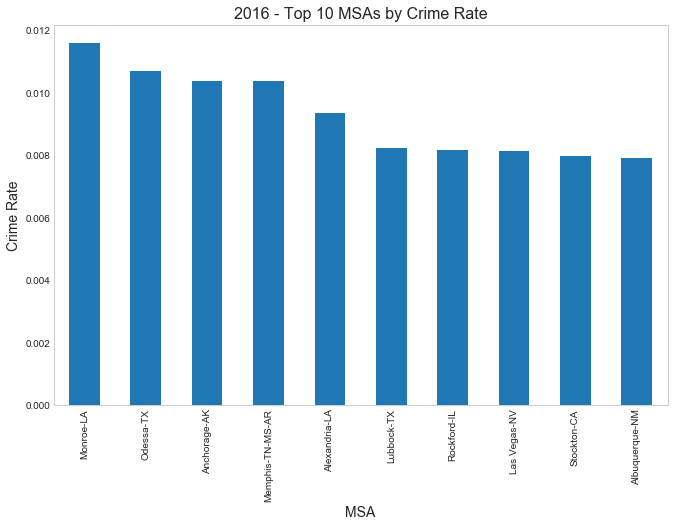

In [128]:
fig, ax = plt.subplots(1,1,figsize=(11,7))
ax=plt_df[plt_df['year']==2015].groupby('join_key')['crime_rate'].sum().sort_values(ascending=False).iloc[0:10].plot(kind='bar',grid=False)
ax.set_title('2016 - Top 10 MSAs by Crime Rate', fontsize=16)
ax.set_xlabel('MSA',fontsize=14)
ax.set_ylabel('Crime Rate',fontsize=14);